In [13]:
# Import libaries
from ema_workbench import Model, RealParameter, IntegerParameter, ScalarOutcome, ema_logging, perform_experiments, CategoricalParameter
from ema_workbench.analysis import feature_scoring, pairs_plotting, regional_sa

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from numpy.lib import recfunctions as rf

# Import model from model.py
from model import AdaptationModel

In [14]:
# Define function to run model and return outcomes
def run_model(number_of_households, probability_of_network_connection, number_of_edges, number_of_nearest_neighbours, time_of_flooding, subsidie_level, information_bias):
    model = AdaptationModel(number_of_households=number_of_households, flood_map_choice="100yr", network="watts_strogatz", 
                            probability_of_network_connection=probability_of_network_connection,
                            number_of_edges=number_of_edges,
                            number_of_nearest_neighbours=number_of_nearest_neighbours,
                            time_of_flooding=time_of_flooding,
                            subsidie_level=subsidie_level,
                            information_bias=information_bias,
                            )
    for step in range(80):
        model.step()
    
    model_data = model.datacollector.get_model_vars_dataframe()

    return {
        "Total_adapted_households_share": model_data.iloc[-1]["Total_adapted_households"]/number_of_households,
        "GovernmentSpendings": model_data.iloc[-1]["GovernmentSpendings"],
    }

In [15]:
# Empoy EMA workbench

ema_logging.LOG_FORMAT = "[%(name)s/%(levelname)s/%(processName)s] %(message)s"
ema_logging.log_to_stderr(ema_logging.INFO)

model = Model("ABModel", function=run_model)  # instantiate the model

# specify uncertainties
model.uncertainties = [
    IntegerParameter("number_of_households", 50, 150),
    RealParameter("probability_of_network_connection", 0.3, 0.5),
    IntegerParameter("number_of_edges", 2, 4),
    IntegerParameter("number_of_nearest_neighbours", 4, 6),
    IntegerParameter("time_of_flooding", 40, 80),
]
# objective risk perceptions


# specify levers
model.levers = [
    CategoricalParameter("subsidie_level", [0, 5000]),
    CategoricalParameter("information_bias", [0.0, 0.1])
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("Total_adapted_households_share"),
    ScalarOutcome("GovernmentSpendings")
]

results = perform_experiments(model, scenarios=100, policies=4)
results

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 100 scenarios * 4 policies * 1 model(s) = 400 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
100%|██████████████████████████████████████| 400/400 [1:05:32<00:00,  9.83s/it]
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] experiments finished


(     number_of_edges  number_of_households  number_of_nearest_neighbours  \
 0                  2                   103                             4   
 1                  3                    72                             5   
 2                  3                    61                             4   
 3                  4                    55                             4   
 4                  2                   112                             5   
 ..               ...                   ...                           ...   
 395                2                    51                             6   
 396                2                   127                             5   
 397                2                   141                             6   
 398                2                    75                             6   
 399                2                   148                             6   
 
      probability_of_network_connection  time_of_flooding information_bias

In [16]:
# Show results including parameter values

experiments, outcomes = results
print(experiments.shape)
print(list(outcomes.keys()))
experiments

(400, 10)
['Total_adapted_households_share', 'GovernmentSpendings']


,number_of_edges,number_of_households,number_of_nearest_neighbours,probability_of_network_connection,time_of_flooding,information_bias,subsidie_level,scenario,policy,model
0,2,103,4,0.338114,76,0.0,5000,16,12,ABModel
1,3,72,5,0.498846,40,0.0,5000,17,12,ABModel
2,3,61,4,0.389126,68,0.0,5000,18,12,ABModel
3,4,55,4,0.404927,70,0.0,5000,19,12,ABModel
4,2,112,5,0.406109,53,0.0,5000,20,12,ABModel
...,...,...,...,...,...,...,...,...,...,...
395,2,51,6,0.402079,60,0.0,0,111,15,ABModel
396,2,127,5,0.348608,76,0.0,0,112,15,ABModel
397,2,141,6,0.373567,61,0.0,0,113,15,ABModel
398,2,75,6,0.440619,48,0.0,0,114,15,ABModel


**Visualizing the data via contrasting the model outcomes**

The pairplot function (seaborn) shows the pairwise realtionship of the results.
Diagonal plots show the univariante distribution to show the amrginal distribution of the data (per column)

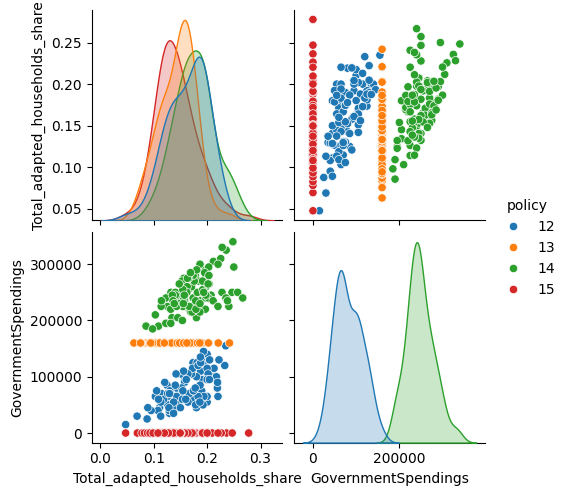

In [17]:
data = pd.DataFrame(outcomes)
data["policy"] = experiments["policy"]

sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

**Feature Scoring**

A global sensitivity analysis is run, using feature scoring to perform a factor prioritisation.
The analysis is run for all outcomes of interest (total adatped households, government spendings).
The resulting heatmap allows to identify which paramter of the model mainly influences the outomes (higher numbers = higher influence).

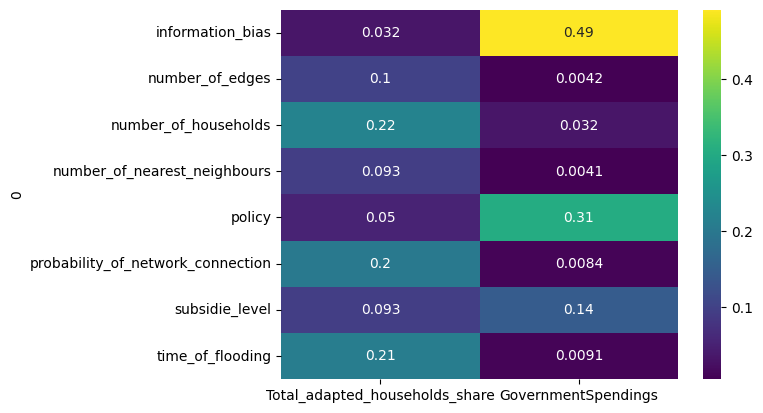

In [18]:
x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()
# do not show this to the reader, put it in the appendix
# rather dive into one specific sensitivity

